#Differential Drive Trajectory Optimization
##Steps:
1) Generate the required model of our differential drive

2) Test the model and make sure it behaves accurately

3) Implement the model using `drake` which is a Non Linear Program Solver

4) Graph everything

Import Statements

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
try:
  import pydrake
  import underactuated
except ImportError:
  !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
  from jupyter_setup import setup_underactuated
  setup_underactuated()

Constants:

`m` - mass of robot

`I` - moment of inertia of robot

`r_bot` - radius of bot (width between wheels / 2)

`r_wheel` - radius of wheel

`k_emf` - emf constant of motor (must take into account gear ratio)

`k_magnet` - constant of magnet (must take into account gear ratio)

Input vector:

$ \mathbf{u} = \begin{bmatrix}
V_L \\
V_R
\end{bmatrix} $

State vector:

$ \mathbf{x} = \begin{bmatrix}
x \\ 
y \\
\theta \\
v \\
\omega \\
\end{bmatrix} $


$f(x, u)$ returns the derivative of x based on the input voltages

$f(x, u) = \mathbf{\dot{x}} = \begin{bmatrix} \dot{x} \\ \dot{y} \\ \dot{\theta}\\ \dot{v} \\ \dot{\omega} \end{bmatrix} = \begin{bmatrix} v*cos(\theta) \\ v*sin(\theta) \\ \omega \\ (\tau(V_r) + \tau(V_l)) / (r * r_{wheel} * m) \\ r_{wheelbase} * (\tau(V_r) - \tau(V_l)) / r_{wheel} \end{bmatrix}$

where $T(V)$ is a function of torque depending on $V_{applied}$

In [ ]:
from pydrake.all import eq, le, ge, MathematicalProgram, Solve, Variable

m = 50. #kg
r_bot = 0.5 #m
r_wheel = 0.0762 #m
I = (1/12.) * (2 * (2*r_bot) ** 2) * m#kg-m^2





stall_torque = 3.87 #N-m
stall_current = 185. #amp
free_speed = 5180. #rpm (Needs to be in r/s)
free_current = 1.2 #amp
operating_voltage = 12. #V
gear_ratio = 1. / 0.096 #ul

free_speed = 2*np.pi*free_speed/60 #r/s

k_emf = operating_voltage / free_speed
k_magnet = stall_torque / operating_voltage

k_emf *= gear_ratio
k_magnet *= gear_ratio * 2

print(k_emf)
print(k_magnet)
'''
k_emf = 2.
k_magnet = 2.'''

0.23043669366587163
6.71875


'\nk_emf = 2.\nk_magnet = 2.'

`model` is $f(x, u)$

`getWheelVelocity` - returns the angular velocity of wheel (need to clarify which wheel it is)

`getWheelTorque` - returns the motor torque of the wheel using `V` (voltage applied) and `vf` (surface velocity of wheel)

In [ ]:
def model(x, u): #state and input vector: f(x, u)
  v = x[3]
  left_wheel_torque = getWheelTorque(u[0], getWheelVelocity(v, x[4], False))
  right_wheel_torque = getWheelTorque(u[1], getWheelVelocity(v, x[4], True))
  dx = np.array([
    v * np.cos(x[2] + 0.),
    v * np.sin(x[2] + 0.),
    x[4],
    (left_wheel_torque + right_wheel_torque) / (r_wheel * m),
    r_bot * (right_wheel_torque - left_wheel_torque) / (r_wheel * I)
  ])

  return dx

def getWheelVelocity(v, w, direction):
  if direction:
    return (v + r_bot * w) / r_wheel
  return (v - r_bot * w) / r_wheel

def getWheelTorque(V, vf):
  voltage_eff = V - k_emf * vf #since vf is wheel speed, k_emf needs to account for the gearing. same for k_magnet
  return k_magnet * voltage_eff


This is just a test to make sure that the above code works. It is assuming the start state is stationary and that the voltage applied is constant.

In this example, left motor is applying 12V and right motor is applying 6V which, intuitively, makes the robot travel in a circle

In [ ]:
x = np.array([0., 0., 0., 0., 0.])
u_const = np.array([12., 6.])

output_x = []
output_y = []

time = []
for i in range(0, 600):
  time.append(0.01)

for i in time:
  x = x + model(x, u_const) * 0.01
  ans = [x[0], x[1]]
  output_x.append(ans[0])
  output_y.append(ans[1])


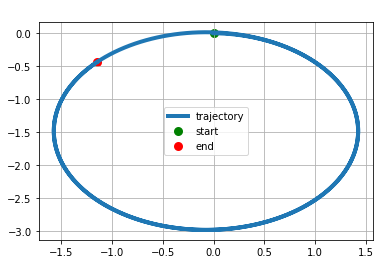

In [ ]:
plt.plot(output_x, output_y, linewidth=4, label='trajectory')
plt.scatter(output_x[0], output_y[0], c='green', label='start', linewidth=3)
plt.scatter(output_x[len(output_x) - 1], output_y[len(output_y) - 1], c='red', label='end', linewidth=3)
plt.title('Test of Trajectory', c='white')
#plt.xlim(0.9, 1)
plt.grid()
plt.legend()

`waypoints` - list of points we want the robot to go to. These are the state variables discussed above

In [ ]:
#Galactice Search Path A RED
waypoints = [
    (np.array([0, 2.286, 0, 0, 0]), 0),
    (np.array([2.286, 2.286]), 20),
    (np.array([3.81, 1.524]), 40),
    (np.array([4.572, 3.81]), 60),
    (np.array([9.144, 3.81, 0, 0, 0]), 90),

]

'''    (np.array([3.81, 1.524]), 240),
    (np.array([4.572, 3.81]), 360),
    (np.array([9.144, 3.81, 0, 0, 0]), 480),
    '''

'''#Galactice Search Path A BLUE
waypoints = [
    (np.array([0, 2.286, 0, 0, 0]), 0),
    (np.array([4.572, 0.762]), 150),
    (np.array([5.334, 3.048]), 250),
    (np.array([6.858, 2.286]), 350),
    (np.array([9.144, 2.286, 0, 0, 0]), 550),
]'''

'''#Galatic Search Path B RED
waypoints = [
    (np.array([0, 3.048, 0, 0, 0]), 0),
    (np.array([2.286, 3.048]), 150),
    (np.array([3.81, 1.524]), 250),
    (np.array([5.334, 3.048]), 350),
    (np.array([9.144, 3.048, 0, 0, 0]), 550),
]'''

'''#Galatic Search Path B BLUE
waypoints = [
    (np.array([0, 3.048, 0, 0, 0]), 0),
    (np.array([4.572, 1.524]), 150),
    (np.array([6.096, 3.048]), 250),
    (np.array([7.62, 1.524]), 350),
    (np.array([9.144, 1.524, 0, 0, 0]), 550),
]'''

'#Galatic Search Path B BLUE\nwaypoints = [\n    (np.array([0, 3.048, 0, 0, 0]), 0),\n    (np.array([4.572, 1.524]), 150),\n    (np.array([6.096, 3.048]), 250),\n    (np.array([7.62, 1.524]), 350),\n    (np.array([9.144, 1.524, 0, 0, 0]), 550),\n]'

`solve` is the actual function which sets everything up and solves for the optimum solution


`N` - is the number of intervals

`T` - is the time per interval (we use this since we do linear approximation)

`u` - empty list in which we will put every value in

`x` - same as `u` except it's for all the state variables


The cost function it is tring to solve is defined as follows:

$J(u, x) = l_w + \int_0^{n+!}{l(x)dt}$ #This is wrong. Will fix later

where $l_w$ is the final value and the integral is the value of $l(x))$, our cost function, being compared to our desired waypoints and our torque. Note, we use quadratic costs since they are guaranteed to have a minimum.

Obviously, we can't actually compute this definite integral, so we solve it numerically using the approximation $f(n+1) = f(n) + f'(n) * T$ where $T$ is our change in time

We also have constraints as follows:
  - The starting point must be the same
  - The voltage $\in [-12, 12]$

We also have costs we would like to minimize:
  - waypoints at current location - desired current location. This is given a lot of weight since we desire this cost a lot
  - We are also adding a cost on torque so the robot doesn't move in a way which is hard on the motors

We then solve for this function, which takes a majority of the time, and get an output of $x$ and $u$.

In [ ]:

#Note in the future may need to make all/some of waypoints constraints since intake can't even handle a few inches of error

def solve():

  #N = waypoints[-1, 1] + 1
  N = waypoints[-1][1] + 1
  T = 0.04 #Frequency robot runs at
  prog = MathematicalProgram()

  u = np.empty((2, N-1), dtype=Variable)
  x = np.empty((5, N), dtype=Variable)
  curvature = np.empty((1, N), dtype=Variable)

  for n in range(N-1):
    u[:,n] = prog.NewContinuousVariables(2, 'u' + str(n))
    x[:,n] = prog.NewContinuousVariables(5, 'x' + str(n))
    curvature[0,n] = prog.NewContinuousVariables(1, 'c' + str(n))

    prog.SetInitialGuess(u[:,n], np.zeros_like(u[:,n]))
    prog.SetInitialGuess(x[:,n], np.zeros_like(x[:,n]))
  x[:,N-1] = prog.NewContinuousVariables(5, 'x' + str(N))
  prog.SetInitialGuess(u, np.ones((2,N-1))*12)

  prog.AddBoundingBoxConstraint(waypoints[0][0], waypoints[0][0], x[:,waypoints[0][1]])

  for n in range(0, N-1):
    prog.AddConstraint(eq(x[:,n+1], x[:,n]+model(x[:,n], u[:,n])*T))
    prog.AddBoundingBoxConstraint(-12, 12, u[:,n]) 
    prog.AddConstraint(eq(x[4, n], x[3, n] * curvature[0, n]))

    prog.AddQuadraticCost(100*(curvature[0,n].dot(curvature[0,n])))

    v = x[3,n]
    torque = np.array([getWheelTorque(u[0,n], getWheelVelocity(x[3,n], x[4,n], False)), getWheelTorque(u[1,n], getWheelVelocity(x[3,n], x[4,n], True))])
    #prog.AddQuadraticCost(torque.dot(torque)) UNCOMMENT LATER

  '''for w in range(len(waypoints)):

    w_ts = waypoints[w][1] #waypoints time stamp
    w_at_w = waypoints[w][0] #waypoint at w

    #dot_expression = x[:, w_ts] - w_at_w
    dot_expression = x[:len(w_at_w), w_ts] - w_at_w

    prog.AddQuadraticCost(10000000*(dot_expression.dot(dot_expression))) # huge weight to minimize waypoint error'''

  for i in range(len(waypoints)):
    prog.AddBoundingBoxConstraint(waypoints[i][0], waypoints[i][0], x[:len(waypoints[i][0]),waypoints[i][1]])

  
    
  result = Solve(prog)

  x_sol = result.GetSolution(x)
  u_sol = result.GetSolution(u)

  assert(result.is_success()), "Optimization failed"

  return x_sol, u_sol, N, T

  print(x_sol)
  print(u_sol)

In [ ]:
x_sol, u_sol, N, T = solve()

Here we are splitting `x_sol` into it's x and y parts (note: it has more information but for a graph, this is enough)

Time taken: 3.6 seconds


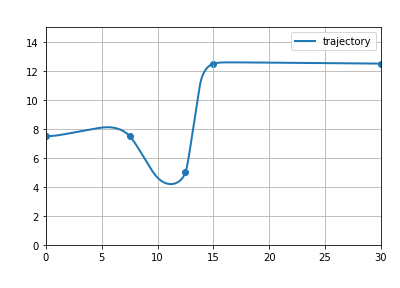

In [ ]:
x_coords = []
y_coords = []
theta = []
velocity = []
angular_velocity = []

for i in range(N):
  x_coords.append((float)("%.4f" % (3.28084 * x_sol[0,i])))
  y_coords.append((float)("%.4f" % (3.28084 * x_sol[1,i])))
  theta.append(x_sol[2,i])
  velocity.append(x_sol[3,i])
  angular_velocity.append(x_sol[4,i])
#print(x_coords)
#print(y_coords)

x_points = []
y_points = []
for i in range(len(waypoints)):
  x_points.append(3.28084 * waypoints[i][0][0])
  y_points.append(3.28084 * waypoints[i][0][1])


#print(u_sol)
plt.plot(x_coords, y_coords, linewidth=2, label='trajectory')
plt.title('Robot Trajectory in terms of x and y', c='white', fontsize=20)
plt.xlabel("x position of robot", c='white', fontsize=15) 
plt.ylabel("y position of robot", c='white', fontsize=15) 
plt.scatter(x_points, y_points)
print("Time taken: " + str(T * waypoints[-1][1]) + " seconds")
plt.xlim(0, 30)
plt.ylim(0, 15)
plt.legend()
plt.grid()

This is doing the same thing but now for `u_sols`. It graphs the voltage each motor needs to apply at each time interval

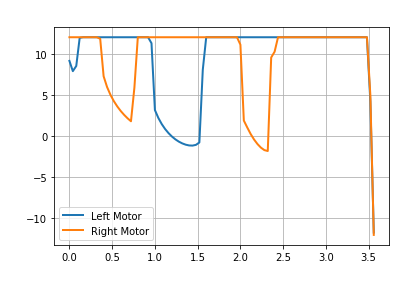

In [ ]:
left = []
right = []

for i in range(N-1):
  left.append((float)("%.4f" % u_sol[0, i]))
  right.append((float)("%.4f" % u_sol[1, i]))

time = []
for i in range(N-1):
  time.append(i * T)

plt.plot(time, left, label="Left Motor", linewidth=2)
plt.plot(time, right, label="Right Motor", linewidth=2)


plt.title("Voltage each motor must apply", fontsize=20, c='white')
plt.xlabel('Time', fontsize=15, c='white')
plt.ylabel('Voltage', fontsize=15, c='white')
plt.legend()
plt.grid()


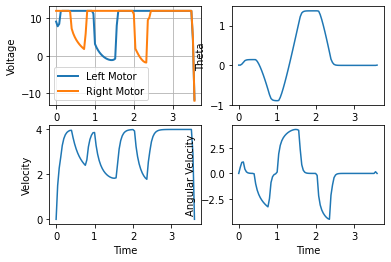

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=False, sharey=False)

ax1.plot(time, left, label="Left Motor", linewidth=2)
ax1.plot(time, right, label="Right Motor", linewidth=2)

time_2 = time.copy()
time_2.append((N-1) * T)
ax2.plot(time_2, theta)

ax3.plot(time_2, velocity)

ax4.plot(time_2, angular_velocity)


#ax1.title("Voltage each motor must apply", fontsize=20, c='white')
ax1.set(xlabel='Time', ylabel='Voltage')
ax2.set(xlabel='Time', ylabel='Theta')
ax3.set(xlabel='Time', ylabel='Velocity')
ax4.set(xlabel='Time', ylabel='Angular Velocity')
#ax1.xlabel('Time', fontsize=15, c='white')
#ax1.ylabel('Voltage', fontsize=15, c='white')
ax1.legend()
ax1.grid()


In [ ]:
with open('waypoints.txt', 'w') as writefile:
    for i in range(len(x_coords)):
      writefile.write((str)(x_coords[i]) + ", " + (str)(y_coords[i])  + ", " + ("%.2f" % (T*i)) + "\n")
      #print((str)(x_coords[i]) + ", " + (str)(y_coords[i])  + ", " + (str)("%.2f" % (T*i)) + "\n")
    
with open('voltages.txt', 'w') as writefile:
    for i in range(len(left)):
      writefile.write((str)(left[i]) + ", " + (str)(right[i])  + ", " + "\n")